In [48]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import pydicom
from sklearn.metrics import f1_score,classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import img_to_array,ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,RandomRotation,\
RandomFlip,RandomTranslation,RandomContrast,RandomZoom
from tensorflow.keras.models import Sequential

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
df=pd.read_csv('../input/merge-labels-and-paths/merge_labels_and_paths.csv')
df.drop(['files_num'],axis=1,inplace=True)
df_for_cleaning=df[:int(len(df)*0.9)].copy()
df_test=df[int(len(df)*0.9):].copy()
df.head()

,BraTS21ID,MGMT_value,best_flair_images,best_t1w_images,best_t1wce_images,best_t2w_images
0,0,1,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
1,2,1,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
2,3,0,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
3,5,1,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...
4,6,1,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...,../input/rsna-miccai-brain-tumor-radiogenomic-...


In [94]:
df_flair_for_cleaning=df_for_cleaning[['BraTS21ID','MGMT_value','best_flair_images']].copy()
df_t1w_for_cleaning=df_for_cleaning[['BraTS21ID','MGMT_value','best_t1w_images']].copy()
df_t1wce_for_cleaning=df_for_cleaning[['BraTS21ID','MGMT_value','best_t1wce_images']].copy()
df_t2w_for_cleaning=df_for_cleaning[['BraTS21ID','MGMT_value','best_t2w_images']].copy()

In [111]:
def load_and_show_one_image_by_index(df_paths,df_labels,i):
    path=df_paths[i]
    img=pydicom.dcmread(path)
    img=img_to_array(img.pixel_array)
    img=tf.image.resize(img,(256,256))
    img=tf.image.central_crop(img, central_fraction=0.7)
    img=tf.image.adjust_contrast(img, contrast_factor=1)
    plt.figure(figsize=(3,3))
    plt.imshow(img,cmap=plt.cm.bone)
    print(df_labels[i])

0
0


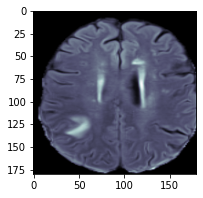

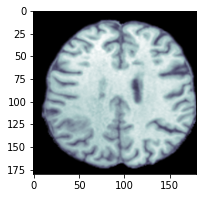

In [350]:
labels=df_flair_for_cleaning['MGMT_value']
# load_and_show_one_image_by_index(df_t1wce_for_cleaning['best_t1wce_images'],    labels,5)
# load_and_show_one_image_by_index(df_t2w_for_cleaning['best_t2w_images'],    labels,5)
load_and_show_one_image_by_index(df_flair_for_cleaning['best_flair_images'],labels,200)
load_and_show_one_image_by_index(df_t1w_for_cleaning['best_t1w_images'],    labels,200)
drop_flair_rows=[103,104,108,110,111,114,115,118,119,124,125,126,127,128,130,132,136,138,140\
    ,141,142,144,146,147,149,151,155,156,157,158,159,160,161,165,166,168,172,147,177,178,179,183,184,188,189,190,191,196,199,200]
drop_t1w_rows=[101,104,108,110,111,114,115,118,119,124,125,126,127,128,130,132,136,138,140\
    ,141,142,144,146,147,149,151,155,156,157,158,159,160,161,164,165,166,168,172,174,177,178,179,183,184,188,189,190,191,195,196,199,200]

In [241]:
drop_flair_rows_100=[0,2,10,11,12,14,15,16,18,19,20,22,25,31,33,40,42,47,51,52,55,56,57,59,\
                 61,62,63,65,70,71,72,73,75,78,79,80,82,83,84,87,90,91,95,96,98,99,100]
drop_t1w_rows_100=[0,2,5,9,10,11,12,14,15,16,19,20,22,25,29,31,33,37,42,47,51,52,55,57,59,\
               61,62,63,65,70,71,72,73,75,78,79,80,81,82,83,84,87,90,91,95,98,99,100]

In [59]:
load_and_show_one_image_by_index(df_t1w_for_cleaning,)

In [228]:
def load_images(list_paths):
    images=[]
    for path in list_paths:
        img=pydicom.dcmread(path)
        img=img_to_array(img.pixel_array)
        img=tf.image.resize(img,(256,256))
        img=tf.image.central_crop(img, central_fraction=0.7)
        img=tf.image.adjust_contrast(img, contrast_factor=1)
        images.append(img)
    return images

In [23]:
flair_images=load_images(df['best_flair_images'])
t1w_images=load_images(df['best_t1w_images'])
t1wce_images=load_images(df['best_t1wce_images'])
t2w_images=load_images(df['best_t2w_images'])

In [7]:
labels=df['MGMT_value']
labels = labels.astype(np.int8)
print(labels.shape)

(582,)


1
1
0
1
1
1
0
1
1
1


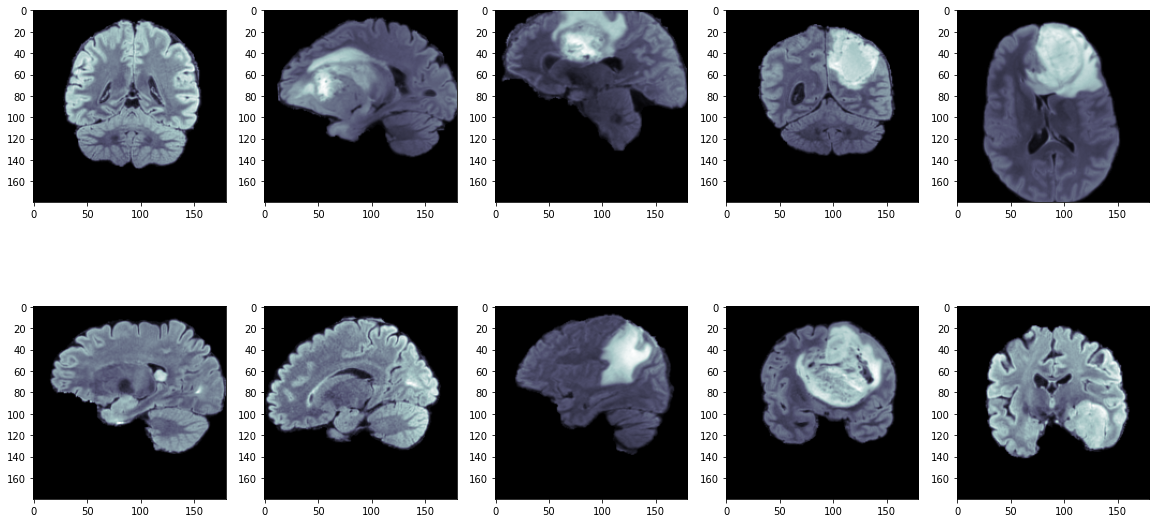

In [37]:
labs=np.array(labels)
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    print(labels[i])
    plt.imshow(flair_images[i],cmap=plt.cm.bone)


1
1
0
1
1
1
0
1
1
1


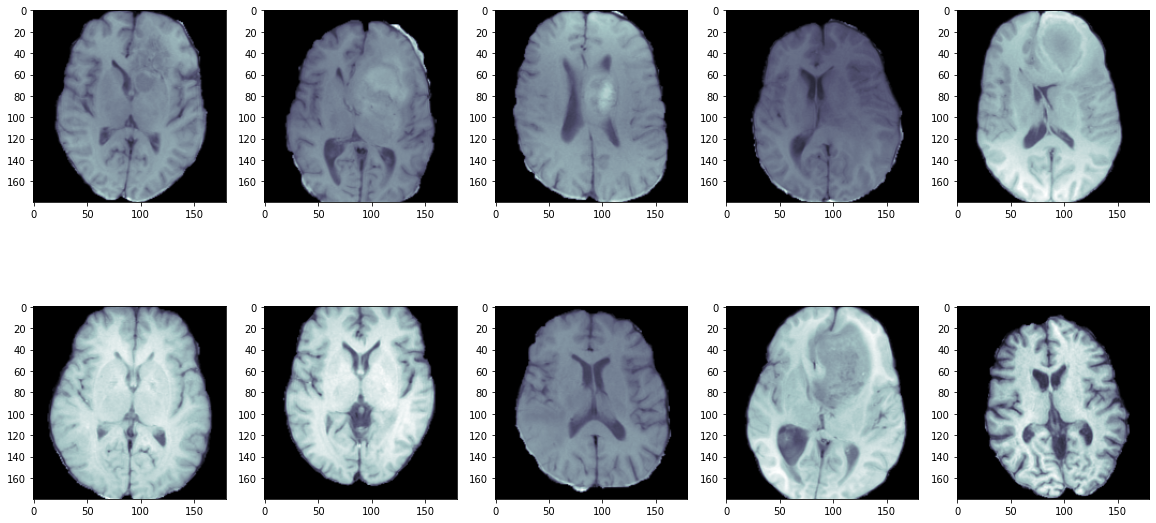

In [36]:
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    print(labels[i])
    plt.imshow(t1w_images[i],cmap=plt.cm.bone)

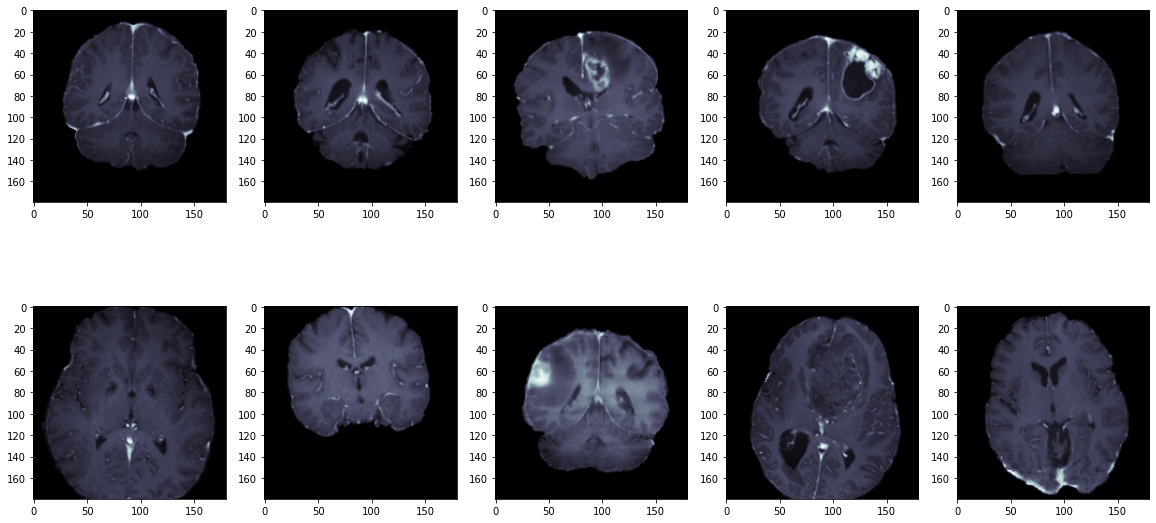

In [39]:
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(t1wce_images[i],cmap=plt.cm.bone)

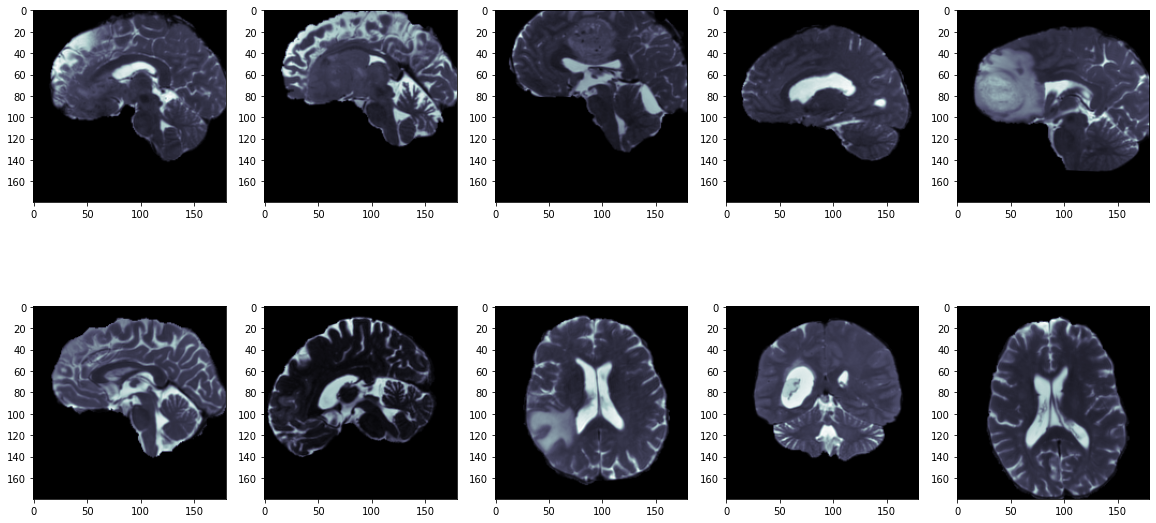

In [40]:
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(t2w_images[i],cmap=plt.cm.bone)

In [71]:
print(flair_images[1].shape)

(180, 180, 1)


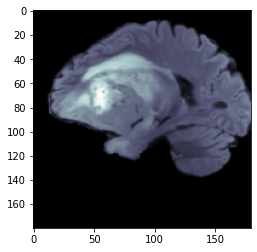

In [66]:
plt.imshow(flair_images[1],cmap=plt.cm.bone)

In [ ]:
len(flair_images)

In [15]:
img_gen = ImageDataGenerator(
    zoom_range=0.3,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

dsg = tf.data.Dataset.from_generator(
    lambda :img_gen.flow(flair_images,y=labels,shuffle=False,batch_size=1), 
    output_types=(tf.float32,tf.int32),
    output_shapes=([1,256,256,1],[1])
)

In [13]:
len(flair_images[:int(582*0.8)])

465

In [14]:
print(flair_images.shape,type(flair_images))

(582, 256, 256, 1) <class 'numpy.ndarray'>


In [8]:
def prepare_train_val_test_input_pipelines(images,labels):
    AUTOTUNE=tf.data.AUTOTUNE
    
    ds=tf.data.Dataset.from_tensor_slices((images,labels)).shuffle(580)
    size=len(ds)
    #train_set
    train_ds=ds.take(int(size*0.7))
    test_val_ds=ds.skip(int(size*0.7))
    #validation_set
    val_ds=test_val_ds.take(int(0.5*len(test_val_ds)))
    #test_set
    test_ds=test_val_ds.skip(int(0.5*len(test_val_ds)))
    #input_pipelines
    train_ds=train_ds.map(lambda x,y:(x/256,y)).shuffle(200).batch(1).cache().prefetch(AUTOTUNE)
    val_ds=val_ds.map(lambda x,y:(x/256,y)).shuffle(50).batch(1).cache().prefetch(AUTOTUNE)
    test_ds=test_ds.map(lambda x,y:(x/256,y)).batch(1).cache().prefetch(AUTOTUNE)
    
    return train_ds,val_ds,test_ds

In [16]:
def prepare_train_val_test_input_pipelines_aug(images,labels):
    AUTOTUNE=tf.data.AUTOTUNE
    size=len(images)
    
    img_gen = ImageDataGenerator(
        zoom_range=0.3,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.2)
    #train_set
    train_ds = tf.data.Dataset.from_generator(
        lambda :img_gen.flow(images[:int(0.8*size)],y=labels[:int(0.8*size)],shuffle=False,batch_size=1,subset='training'), 
        output_types=(tf.float32,tf.int32),
        output_shapes=([1,256,256,1],[1])
        )
    #validation_set
    val_ds=tf.data.Dataset.from_generator(
        lambda :img_gen.flow(images[:int(0.8*size)],y=labels[:int(0.8*size)],shuffle=False,batch_size=1,subset='validation'), 
        output_types=(tf.float32,tf.int32),
        output_shapes=([1,256,256,1],[1])
        )
    #test_set
    test_ds=tf.data.Dataset.from_tensor_slices((images[int(0.8*size):],labels[int(0.8*size):]))
    #input_pipelines
    train_ds=train_ds.map(lambda x,y:(x/256,y)).shuffle(200).batch(1).cache().prefetch(AUTOTUNE)
    val_ds=val_ds.map(lambda x,y:(x/256,y)).shuffle(200).batch(1).cache().prefetch(AUTOTUNE)
    test_ds=test_ds.map(lambda x,y:(x/256,y)).batch(1).cache().prefetch(AUTOTUNE)
    
    return train_ds,val_ds,test_ds

In [9]:
def train(train_ds,val_ds,epochs=20):
    print('preparing...')
    cnn=Sequential([
        
        Conv2D(64,kernel_size=(3,3),activation='relu',padding='same',input_shape=(256,256,1)),
        MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='valid'),
        Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'),
        MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='valid'),
        Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'),
        MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='valid'),
        Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'),
        MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='valid'),
        Flatten(),
        Dense(1,activation='sigmoid')
    ])
    print('compiling...')
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    print('training...')
    cnn.fit(train_ds,validation_data=val_ds,epochs=epochs,verbose=2)
    print('end training...')
    return cnn

In [10]:
def train_v2(train_ds,val_ds,epochs=20):
    print('preparing...')
    cnn=Sequential([
        Conv2D(32,kernel_size=(3,3),activation='relu',padding='same',input_shape=(180,180,1)),
        MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='valid'),
        Dropout(0.5),
        Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'),
        MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='valid'),
        Dropout(0.7),
        Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'),
        MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='valid'),
        Dropout(0.7),
        Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'),
        MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='valid'),
        Dropout(0.5),
        Flatten(),
        Dense(1,activation='sigmoid')
    ])
    print('compiling...')
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    print('training...')
    cnn.fit(train_ds,validation_data=val_ds,epochs=epochs,verbose=2)
    print('end training...')
    return cnn

In [29]:
def score(model,test_ds):
    y_pred=[np.int(np.round(i)) for i in model.predict(test_ds)]
    y_true=[]
    for im,y in test_ds:
        y_true.append(y)
    y_true=np.array(y_true)
    score=f1_score(y_true,y_pred)
    print(classification_report(y_true,y_pred))
    print('y_true',y_true[:10])
    print('y_pred:',y_pred[:10])
    return score

In [17]:
#train_flair_ds,val_flair_ds,test_flair_ds=prepare_train_val_test_input_pipelines(flair_images,labels)

In [ ]:
#flair_cnn=train(train_flair_ds,val_flair_ds)

In [ ]:
#score(flair_cnn,test_flair_ds)

In [ ]:
#flair_cnn_v2=train_v2(train_flair_ds,val_flair_ds)

In [ ]:
#score(flair_cnn_v2,test_flair_ds)

In [12]:
train_flair_ds,val_flair_ds,test_flair_ds=prepare_train_val_test_input_pipelines(flair_images,labels)

In [13]:
flair_cnn_v2=train_v2(train_flair_ds,val_flair_ds,70)

preparing...
compiling...
training...
Epoch 1/70


2022-09-09 02:51:58.666349: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-09 02:51:59.650456: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


407/407 - 10s - loss: 2.1937 - accuracy: 0.4644 - val_loss: 0.6932 - val_accuracy: 0.4828
Epoch 2/70
407/407 - 2s - loss: 0.7230 - accuracy: 0.5307 - val_loss: 0.6930 - val_accuracy: 0.5172
Epoch 3/70
407/407 - 3s - loss: 0.7010 - accuracy: 0.5209 - val_loss: 0.6918 - val_accuracy: 0.5977
Epoch 4/70
407/407 - 3s - loss: 0.6795 - accuracy: 0.5504 - val_loss: 0.6725 - val_accuracy: 0.5632
Epoch 5/70
407/407 - 3s - loss: 0.6713 - accuracy: 0.5946 - val_loss: 0.6492 - val_accuracy: 0.6207
Epoch 6/70
407/407 - 3s - loss: 0.7018 - accuracy: 0.5921 - val_loss: 0.6433 - val_accuracy: 0.6897
Epoch 7/70
407/407 - 3s - loss: 0.6127 - accuracy: 0.6634 - val_loss: 0.6237 - val_accuracy: 0.6552
Epoch 8/70
407/407 - 3s - loss: 0.6201 - accuracy: 0.7150 - val_loss: 0.6147 - val_accuracy: 0.6552
Epoch 9/70
407/407 - 3s - loss: 0.5494 - accuracy: 0.7346 - val_loss: 0.5470 - val_accuracy: 0.6782
Epoch 10/70
407/407 - 3s - loss: 0.5081 - accuracy: 0.7101 - val_loss: 0.5101 - val_accuracy: 0.7241
Epoch 11/

In [31]:
score(flair_cnn_v2,test_flair_ds)

              precision    recall  f1-score   support

           0       0.82      0.89      0.85        45
           1       0.87      0.79      0.83        43

    accuracy                           0.84        88
   macro avg       0.84      0.84      0.84        88
weighted avg       0.84      0.84      0.84        88

y_true [[1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]]
y_pred: [1, 0, 1, 1, 0, 1, 0, 0, 0, 1]


0.8292682926829267

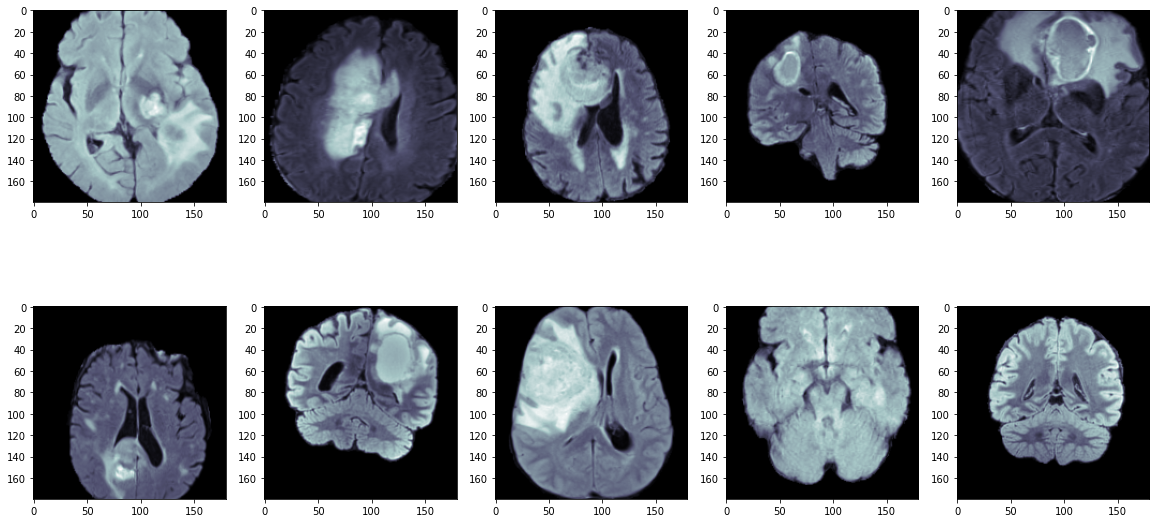

In [35]:
plt.figure(figsize=(20,10))
i=0
for img,l in test_flair_ds.take(10).as_numpy_iterator():
    plt.subplot(2,5,i+1)
    i=i+1
    plt.imshow(img[0],cmap=plt.cm.bone)


In [ ]:
flair_images=load_images(df['best_flair_images'])

In [33]:
plt.figure(figsize=(20,10))
i=0
for img,l in test_t1w_ds.take(10).as_numpy_iterator():
    plt.subplot(2,5,i+1)
    i=i+1
    plt.imshow(img[0],cmap=plt.cm.bone)

NameError: name 'test_t1w_ds' is not defined

<Figure size 1440x720 with 0 Axes>

In [30]:
score(flair_cnn_v2,train_flair_ds)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       194
           1       0.99      0.94      0.96       213

    accuracy                           0.96       407
   macro avg       0.96      0.96      0.96       407
weighted avg       0.96      0.96      0.96       407

y_true [[1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]]
y_pred: [1, 0, 0, 1, 0, 1, 1, 0, 0, 0]


0.9615384615384616

In [203]:
train_flair_ds,val_flair_ds,test_flair_ds=prepare_train_val_test_input_pipelines(flair_images,labels)

In [225]:
train_flair_ds,val_flair_ds,test_flair_ds=prepare_train_val_test_input_pipelines(flair_images,labels)
score(flair_cnn_v2,train_flair_ds)

              precision    recall  f1-score   support

           0       0.46      1.00      0.63       189
           1       0.00      0.00      0.00       218

    accuracy                           0.46       407
   macro avg       0.23      0.50      0.32       407
weighted avg       0.22      0.46      0.29       407



0.0

In [ ]:
#train_t1w_ds,val_t1w_ds,test_t1w_ds=prepare_train_val_test_input_pipelines(t1w_images,labels)
#t1w_cnn=train(train_t1w_ds,val_t1w_ds,30)
#score(t1w_cnn,test_t1w_ds)

In [ ]:
train_t1w_ds,val_t1w_ds,test_t1w_ds=prepare_train_val_test_input_pipelines(t1w_images,labels)
t1w_cnn_v2=train_v2(train_t1w_ds,val_t1w_ds)
score(t1w_cnn_v2,test_t1w_ds)

In [ ]:
train_t1wce_ds,val_t1wce_ds,test_t1wce_ds=prepare_train_val_test_input_pipelines(t1wce_images,labels)
t1wce_cnn_v2=train_v2(train_t1wce_ds,val_t1wce_ds,30)

print('score test :',score(t1wce_cnn_v2,test_t1wce_ds))

In [ ]:
train_t2w_ds,val_t2w_ds,test_t2w_ds=prepare_train_val_test_input_pipelines(t2w_images,labels)
t2w_cnn_v2=train_v2(train_t2w_ds,val_t2w_ds)
print('test score',score(t2w_cnn_v2,test_t2w_ds))

In [ ]:
def final_prediction(test_flair,test_t1w,test_t1wce,test_t2w):
    y_flair_pred=flair_cnn_v2.predict(test_flair)
    y_t1w_pred=t1w_cnn_v2.predict(test_t1w)
    y_t1wce_pred=t1wce_cnn_v2.predict(test_t1wce)
    y_t2w_pred=t2w_cnn_v2.predict(test_t1w)
    sum_y=[y_flair_pred[i] + y_t1w_pred[i] + y_t1wce_pred[i] + y_t2w_pred[i] for i in range(len(y_flair_pred)) ]
    y_pred=[np.int(np.round(i/4)) for i in sum_y]
    return y_pred

In [ ]:
y_pred=final_prediction(test_flair_ds,test_t1w_ds,test_t1wce_ds,test_t2w_ds)

In [ ]:
y_true=[]
for im,y in test_flair_ds:
    y_true.append(y)
y_true=np.array(y_true)
score=f1_score(y_true,y_pred)
score

In [ ]:
print(classification_report(y_true,y_pred))

In [ ]:
sample_submission_df=pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv')
sample_submission_df.head()

In [ ]:
def bytes_to_str(byte_filename):
    return str(byte_filename).split('\'')[1]

In [ ]:
def best_image(ds_paths):
    
    s=0
    filep=''
    for filename in ds_paths.as_numpy_iterator():
        img=pydicom.dcmread(bytes_to_str(filename))
        sp=np.array(img.pixel_array).sum()
        if(sp>s):
            s=sp
            filep=bytes_to_str(filename)
    #best_img=pydicom.dcmread(filep)
    return filep

In [ ]:
def image_selection(test_ds_files):
    i=0
    files_num=[]
    best_flair_images=[]
    best_t1w_images=[]
    best_t1wce_images=[]
    best_t2w_images=[]
    for filename in test_ds_files.as_numpy_iterator():
        path=bytes_to_str(filename)
        FLAIR_PATH=path+'/FLAIR/*'
        T1w_PATH=path+'/T1w/*'
        T1wCE_PATH=path+'/T1wCE/*'
        T2w_PATH=path+'/T2w/*'
        ds_files_FLAIR=tf.data.Dataset.list_files(FLAIR_PATH,)
        ds_files_T1w=tf.data.Dataset.list_files(T1w_PATH)
        ds_files_T1wCE=tf.data.Dataset.list_files(T1wCE_PATH)
        ds_files_T2w=tf.data.Dataset.list_files(T2w_PATH)
        file_num=path.split('/')[-1]
        files_num.append(int(file_num))
        best_flair_images.append(best_image(ds_files_FLAIR))
        best_t1w_images.append(best_image(ds_files_T1w))
        best_t1wce_images.append(best_image(ds_files_T1wCE))
        best_t2w_images.append(best_image(ds_files_T2w))
    return files_num,best_flair_images,best_t1w_images,best_t1wce_images,best_t2w_images

In [ ]:
ds_test_files=tf.data.Dataset.list_files('../input/rsna-miccai-brain-tumor-radiogenomic-classification/test/*')
files_num,best_flair_images,best_t1w_images,best_t1wce_images,best_t2w_images=image_selection(ds_test_files.batch(1))

In [ ]:
dict={
    'files_num':files_num,
    'best_flair_images':best_flair_images,
    'best_t1w_images':best_t1w_images,
    'best_t1wce_images':best_t1wce_images,
    'best_t2w_images':best_t2w_images
}
df=pd.DataFrame(dict)
df.head()
df.to_csv('test_best_images_paths.csv',index=False)

In [ ]:
test_best_images_paths=pd.read_csv('./test_best_images_paths.csv')
test_best_images_paths.head()

In [ ]:
ds = pydicom.dcmread(test_best_images_paths['best_flair_images'][0])
plt.imshow(ds.pixel_array, cmap=plt.cm.bone) 

In [ ]:
ds=pd.merge(sample_submission_df,test_best_images_paths,left_on=['BraTS21ID'],right_on=['files_num'])
ds.head()

In [ ]:
ds=ds.dropna(axis=0)
ds.drop(['files_num'],axis=1,inplace=True)
ds.to_csv('test_merge_labels_and_paths.csv',index=False)
ds.info()

In [ ]:
sub_flair_images=load_images(ds['best_flair_images'])
sub_t1w_images=load_images(ds['best_t1w_images'])
sub_t1wce_images=load_images(ds['best_t1wce_images'])
sub_t2w_images=load_images(ds['best_t2w_images'])

In [ ]:
print(sub_flair_images.shape,type(sub_flair_images))

In [ ]:
def prepare_submission_input_pipeline(images):
    AUTOTUNE=tf.data.AUTOTUNE
    test_ds=tf.data.Dataset.from_tensor_slices(images)
    test_ds=test_ds.map(lambda x:x/256).batch(1).cache().prefetch(AUTOTUNE)
    return test_ds

In [ ]:
submission_pipeline_flair=prepare_submission_input_pipeline(sub_flair_images)
submission_pipeline_t1w=prepare_submission_input_pipeline(sub_t1w_images)
submission_pipeline_t1wce=prepare_submission_input_pipeline(sub_t1wce_images)
submission_pipeline_t2w=prepare_submission_input_pipeline(sub_t2w_images)

In [ ]:
y_pred_submittion=final_prediction(submission_pipeline_flair,submission_pipeline_t1w,submission_pipeline_t1wce,submission_pipeline_t2w)

In [ ]:
sample_submission_df['MGMT_value']=y_pred_submittion

In [ ]:
sample_submission_df.to_csv('submission.csv',index=False)

In [ ]:
sample_submission_df.head()